<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[02:53:37] /work/mxnet/src/storage/storage.cc:205: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


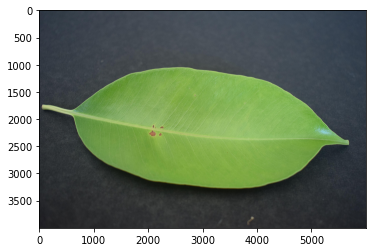

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

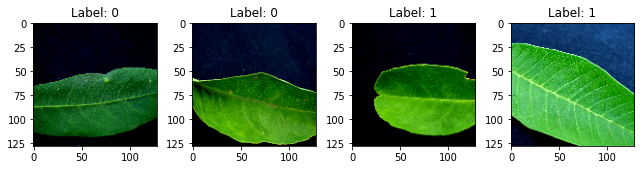

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[02:53:43] /work/mxnet/src/storage/storage.cc:205: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[02:53:45] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:107: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.24737600508312 samples/sec                   batch loss = 1.5856643915176392 | accuracy = 0.55


Epoch[1] Batch[10] Speed: 1.2603750095126025 samples/sec                   batch loss = 0.44748061895370483 | accuracy = 0.625


Epoch[1] Batch[15] Speed: 1.265198265259575 samples/sec                   batch loss = 0.6402939558029175 | accuracy = 0.65


Epoch[1] Batch[20] Speed: 1.2637559651383503 samples/sec                   batch loss = 0.4587079882621765 | accuracy = 0.6125


Epoch[1] Batch[25] Speed: 1.271404594124257 samples/sec                   batch loss = 0.7708591222763062 | accuracy = 0.62


Epoch[1] Batch[30] Speed: 1.2633717864707026 samples/sec                   batch loss = 0.354431688785553 | accuracy = 0.65


Epoch[1] Batch[35] Speed: 1.2706175241324855 samples/sec                   batch loss = 0.49496597051620483 | accuracy = 0.6357142857142857


Epoch[1] Batch[40] Speed: 1.2688507024306985 samples/sec                   batch loss = 0.4000146687030792 | accuracy = 0.63125


Epoch[1] Batch[45] Speed: 1.2681257370125363 samples/sec                   batch loss = 0.4645093083381653 | accuracy = 0.6277777777777778


Epoch[1] Batch[50] Speed: 1.2653495093656681 samples/sec                   batch loss = 0.5262951254844666 | accuracy = 0.63


Epoch[1] Batch[55] Speed: 1.2677641875623031 samples/sec                   batch loss = 0.36824408173561096 | accuracy = 0.6227272727272727


Epoch[1] Batch[60] Speed: 1.2690294096067398 samples/sec                   batch loss = 0.735002338886261 | accuracy = 0.625


Epoch[1] Batch[65] Speed: 1.268344702576354 samples/sec                   batch loss = 0.6142040491104126 | accuracy = 0.6346153846153846


Epoch[1] Batch[70] Speed: 1.2657358468872406 samples/sec                   batch loss = 0.48789680004119873 | accuracy = 0.6178571428571429


Epoch[1] Batch[75] Speed: 1.2713707764901054 samples/sec                   batch loss = 0.5230599641799927 | accuracy = 0.6066666666666667


Epoch[1] Batch[80] Speed: 1.2631349435681005 samples/sec                   batch loss = 0.5897247195243835 | accuracy = 0.603125


Epoch[1] Batch[85] Speed: 1.2629728192206073 samples/sec                   batch loss = 0.8623749017715454 | accuracy = 0.6


Epoch[1] Batch[90] Speed: 1.2550463404391117 samples/sec                   batch loss = 0.577426016330719 | accuracy = 0.5972222222222222


Epoch[1] Batch[95] Speed: 1.2407085606679227 samples/sec                   batch loss = 1.0084072351455688 | accuracy = 0.5921052631578947


Epoch[1] Batch[100] Speed: 1.2617753402470242 samples/sec                   batch loss = 0.3963674306869507 | accuracy = 0.6025


Epoch[1] Batch[105] Speed: 1.258461690097466 samples/sec                   batch loss = 0.43397417664527893 | accuracy = 0.6071428571428571


Epoch[1] Batch[110] Speed: 1.2605850551101576 samples/sec                   batch loss = 0.6347019076347351 | accuracy = 0.6068181818181818


Epoch[1] Batch[115] Speed: 1.2632903557603326 samples/sec                   batch loss = 0.39987826347351074 | accuracy = 0.6130434782608696


Epoch[1] Batch[120] Speed: 1.269229003048849 samples/sec                   batch loss = 1.208953857421875 | accuracy = 0.6125


Epoch[1] Batch[125] Speed: 1.2708060663714746 samples/sec                   batch loss = 0.5083324909210205 | accuracy = 0.614


Epoch[1] Batch[130] Speed: 1.265550428898925 samples/sec                   batch loss = 0.5632052421569824 | accuracy = 0.6134615384615385


Epoch[1] Batch[135] Speed: 1.2707612115378513 samples/sec                   batch loss = 0.48105987906455994 | accuracy = 0.6148148148148148


Epoch[1] Batch[140] Speed: 1.2661400974244414 samples/sec                   batch loss = 0.8666574358940125 | accuracy = 0.6160714285714286


Epoch[1] Batch[145] Speed: 1.2700415610204834 samples/sec                   batch loss = 0.7030509114265442 | accuracy = 0.6155172413793103


Epoch[1] Batch[150] Speed: 1.2727239210831813 samples/sec                   batch loss = 0.5620515942573547 | accuracy = 0.615


Epoch[1] Batch[155] Speed: 1.2739451836273765 samples/sec                   batch loss = 0.4924054741859436 | accuracy = 0.6161290322580645


Epoch[1] Batch[160] Speed: 1.2693880314978503 samples/sec                   batch loss = 0.5336667895317078 | accuracy = 0.6140625


Epoch[1] Batch[165] Speed: 1.2632271971113527 samples/sec                   batch loss = 1.026517391204834 | accuracy = 0.6121212121212121


Epoch[1] Batch[170] Speed: 1.268957805521654 samples/sec                   batch loss = 0.4594796597957611 | accuracy = 0.6161764705882353


Epoch[1] Batch[175] Speed: 1.2592946374494858 samples/sec                   batch loss = 0.4480994939804077 | accuracy = 0.6185714285714285


Epoch[1] Batch[180] Speed: 1.260895137593401 samples/sec                   batch loss = 0.31772977113723755 | accuracy = 0.6208333333333333


Epoch[1] Batch[185] Speed: 1.2635588504918154 samples/sec                   batch loss = 0.3513757586479187 | accuracy = 0.6270270270270271


Epoch[1] Batch[190] Speed: 1.2593380247330594 samples/sec                   batch loss = 0.7848597764968872 | accuracy = 0.6289473684210526


Epoch[1] Batch[195] Speed: 1.2570860316214845 samples/sec                   batch loss = 0.6177738904953003 | accuracy = 0.632051282051282


Epoch[1] Batch[200] Speed: 1.2585545840105687 samples/sec                   batch loss = 0.6648129820823669 | accuracy = 0.6325


Epoch[1] Batch[205] Speed: 1.2359223647132906 samples/sec                   batch loss = 0.6452350616455078 | accuracy = 0.6341463414634146


Epoch[1] Batch[210] Speed: 1.2403939281292022 samples/sec                   batch loss = 0.5707330703735352 | accuracy = 0.6333333333333333


Epoch[1] Batch[215] Speed: 1.2601994885805703 samples/sec                   batch loss = 0.37414172291755676 | accuracy = 0.6383720930232558


Epoch[1] Batch[220] Speed: 1.264303182887688 samples/sec                   batch loss = 0.47229892015457153 | accuracy = 0.6363636363636364


Epoch[1] Batch[225] Speed: 1.2649053267080903 samples/sec                   batch loss = 0.4739236831665039 | accuracy = 0.6388888888888888


Epoch[1] Batch[230] Speed: 1.2651904416269972 samples/sec                   batch loss = 0.5195422768592834 | accuracy = 0.6391304347826087


Epoch[1] Batch[235] Speed: 1.2675456139043968 samples/sec                   batch loss = 0.5455182194709778 | accuracy = 0.6414893617021277


Epoch[1] Batch[240] Speed: 1.262118194790243 samples/sec                   batch loss = 0.5822186470031738 | accuracy = 0.6416666666666667


Epoch[1] Batch[245] Speed: 1.27290516967197 samples/sec                   batch loss = 0.6568703055381775 | accuracy = 0.6428571428571429


Epoch[1] Batch[250] Speed: 1.2705029247241442 samples/sec                   batch loss = 0.5293785333633423 | accuracy = 0.646


Epoch[1] Batch[255] Speed: 1.270785563661924 samples/sec                   batch loss = 0.08877529203891754 | accuracy = 0.6480392156862745


Epoch[1] Batch[260] Speed: 1.2691417271966678 samples/sec                   batch loss = 1.020280122756958 | accuracy = 0.65


Epoch[1] Batch[265] Speed: 1.2635473357961282 samples/sec                   batch loss = 0.755728542804718 | accuracy = 0.6481132075471698


Epoch[1] Batch[270] Speed: 1.2671556826144053 samples/sec                   batch loss = 1.0143100023269653 | accuracy = 0.649074074074074


Epoch[1] Batch[275] Speed: 1.2566449009314122 samples/sec                   batch loss = 0.4115493595600128 | accuracy = 0.6509090909090909


Epoch[1] Batch[280] Speed: 1.2657957231035641 samples/sec                   batch loss = 0.5821378827095032 | accuracy = 0.6526785714285714


Epoch[1] Batch[285] Speed: 1.2387183354533353 samples/sec                   batch loss = 0.7644873857498169 | accuracy = 0.6526315789473685


Epoch[1] Batch[290] Speed: 1.2471558752313066 samples/sec                   batch loss = 0.2575501799583435 | accuracy = 0.6543103448275862


Epoch[1] Batch[295] Speed: 1.2598241855645997 samples/sec                   batch loss = 0.31275421380996704 | accuracy = 0.6550847457627119


Epoch[1] Batch[300] Speed: 1.2647908018317633 samples/sec                   batch loss = 0.48610275983810425 | accuracy = 0.6566666666666666


Epoch[1] Batch[305] Speed: 1.2626630445253646 samples/sec                   batch loss = 0.5340213179588318 | accuracy = 0.6581967213114754


Epoch[1] Batch[310] Speed: 1.2737954561536655 samples/sec                   batch loss = 0.2982088625431061 | accuracy = 0.660483870967742


Epoch[1] Batch[315] Speed: 1.2673509533412817 samples/sec                   batch loss = 0.671337902545929 | accuracy = 0.6611111111111111


Epoch[1] Batch[320] Speed: 1.270739651542936 samples/sec                   batch loss = 0.2715713381767273 | accuracy = 0.6625


Epoch[1] Batch[325] Speed: 1.263501088802039 samples/sec                   batch loss = 1.4639784097671509 | accuracy = 0.6623076923076923


Epoch[1] Batch[330] Speed: 1.2678301001071866 samples/sec                   batch loss = 1.0051652193069458 | accuracy = 0.6613636363636364


Epoch[1] Batch[335] Speed: 1.265228988264977 samples/sec                   batch loss = 0.11625156551599503 | accuracy = 0.6649253731343283


Epoch[1] Batch[340] Speed: 1.2700455028802946 samples/sec                   batch loss = 0.4647732973098755 | accuracy = 0.6669117647058823


Epoch[1] Batch[345] Speed: 1.2665744385060247 samples/sec                   batch loss = 0.25649237632751465 | accuracy = 0.6681159420289855


Epoch[1] Batch[350] Speed: 1.257371872555381 samples/sec                   batch loss = 0.3486775755882263 | accuracy = 0.6714285714285714


Epoch[1] Batch[355] Speed: 1.257517857955304 samples/sec                   batch loss = 0.5494256615638733 | accuracy = 0.6732394366197183


Epoch[1] Batch[360] Speed: 1.256681987298215 samples/sec                   batch loss = 0.46166208386421204 | accuracy = 0.675


Epoch[1] Batch[365] Speed: 1.2376058252958593 samples/sec                   batch loss = 0.8169091939926147 | accuracy = 0.6753424657534246


Epoch[1] Batch[370] Speed: 1.2523082347928653 samples/sec                   batch loss = 0.5117661356925964 | accuracy = 0.6756756756756757


Epoch[1] Batch[375] Speed: 1.2612928878792193 samples/sec                   batch loss = 0.22230450809001923 | accuracy = 0.6766666666666666


Epoch[1] Batch[380] Speed: 1.2660690100980099 samples/sec                   batch loss = 0.9456960558891296 | accuracy = 0.6769736842105263


Epoch[1] Batch[385] Speed: 1.268223610259651 samples/sec                   batch loss = 0.49108028411865234 | accuracy = 0.6779220779220779


Epoch[1] Batch[390] Speed: 1.274175259916407 samples/sec                   batch loss = 0.4531659483909607 | accuracy = 0.6794871794871795


Epoch[1] Batch[395] Speed: 1.276757939567366 samples/sec                   batch loss = 0.6622076034545898 | accuracy = 0.680379746835443


Epoch[1] Batch[400] Speed: 1.2744741541913835 samples/sec                   batch loss = 0.580204427242279 | accuracy = 0.681875


Epoch[1] Batch[405] Speed: 1.2632415594421027 samples/sec                   batch loss = 3.2375738620758057 | accuracy = 0.6814814814814815


Epoch[1] Batch[410] Speed: 1.2679262029140994 samples/sec                   batch loss = 0.1414676457643509 | accuracy = 0.6810975609756098


Epoch[1] Batch[415] Speed: 1.2570626726500191 samples/sec                   batch loss = 1.696478247642517 | accuracy = 0.6801204819277108


Epoch[1] Batch[420] Speed: 1.265306088587783 samples/sec                   batch loss = 0.297357976436615 | accuracy = 0.6815476190476191


Epoch[1] Batch[425] Speed: 1.2635438148153784 samples/sec                   batch loss = 0.3436400890350342 | accuracy = 0.6823529411764706


Epoch[1] Batch[430] Speed: 1.2610585298909192 samples/sec                   batch loss = 0.848425030708313 | accuracy = 0.6831395348837209


Epoch[1] Batch[435] Speed: 1.2594561969822085 samples/sec                   batch loss = 0.3585888147354126 | accuracy = 0.6844827586206896


Epoch[1] Batch[440] Speed: 1.2493221600477473 samples/sec                   batch loss = 1.5966553688049316 | accuracy = 0.6852272727272727


Epoch[1] Batch[445] Speed: 1.2285276603721635 samples/sec                   batch loss = 0.21151171624660492 | accuracy = 0.6870786516853933


Epoch[1] Batch[450] Speed: 1.2556406367887867 samples/sec                   batch loss = 0.5511398911476135 | accuracy = 0.6883333333333334


Epoch[1] Batch[455] Speed: 1.257042140077512 samples/sec                   batch loss = 0.4397973418235779 | accuracy = 0.6879120879120879


Epoch[1] Batch[460] Speed: 1.2562877978487705 samples/sec                   batch loss = 0.19151639938354492 | accuracy = 0.6885869565217392


Epoch[1] Batch[465] Speed: 1.2725808513067167 samples/sec                   batch loss = 0.2614757716655731 | accuracy = 0.6897849462365592


Epoch[1] Batch[470] Speed: 1.2691972213434208 samples/sec                   batch loss = 0.31461790204048157 | accuracy = 0.6914893617021277


Epoch[1] Batch[475] Speed: 1.275551355049638 samples/sec                   batch loss = 0.31664931774139404 | accuracy = 0.6921052631578948


Epoch[1] Batch[480] Speed: 1.270780750915182 samples/sec                   batch loss = 0.24924524128437042 | accuracy = 0.6916666666666667


Epoch[1] Batch[485] Speed: 1.263791473249878 samples/sec                   batch loss = 0.6743317246437073 | accuracy = 0.6922680412371134


Epoch[1] Batch[490] Speed: 1.2674736983895654 samples/sec                   batch loss = 0.6537420153617859 | accuracy = 0.6918367346938775


Epoch[1] Batch[495] Speed: 1.271853353868304 samples/sec                   batch loss = 0.9683141112327576 | accuracy = 0.6909090909090909


Epoch[1] Batch[500] Speed: 1.2706991322820378 samples/sec                   batch loss = 0.525277316570282 | accuracy = 0.692


Epoch[1] Batch[505] Speed: 1.269594847283562 samples/sec                   batch loss = 0.603359043598175 | accuracy = 0.692079207920792


Epoch[1] Batch[510] Speed: 1.2609341810902743 samples/sec                   batch loss = 0.39377278089523315 | accuracy = 0.6926470588235294


Epoch[1] Batch[515] Speed: 1.2583868373996423 samples/sec                   batch loss = 0.3563206195831299 | accuracy = 0.6912621359223301


Epoch[1] Batch[520] Speed: 1.2505428055134684 samples/sec                   batch loss = 0.5394179821014404 | accuracy = 0.6913461538461538


Epoch[1] Batch[525] Speed: 1.2384258280172944 samples/sec                   batch loss = 0.36259889602661133 | accuracy = 0.6923809523809524


Epoch[1] Batch[530] Speed: 1.2538639318430553 samples/sec                   batch loss = 0.08923926949501038 | accuracy = 0.6938679245283019


Epoch[1] Batch[535] Speed: 1.2577675913517203 samples/sec                   batch loss = 0.3976469039916992 | accuracy = 0.694392523364486


Epoch[1] Batch[540] Speed: 1.2577036637334869 samples/sec                   batch loss = 0.468972384929657 | accuracy = 0.6953703703703704


Epoch[1] Batch[545] Speed: 1.2623744131580805 samples/sec                   batch loss = 0.46328458189964294 | accuracy = 0.6954128440366972


Epoch[1] Batch[550] Speed: 1.2614625483831992 samples/sec                   batch loss = 0.32711178064346313 | accuracy = 0.695


Epoch[1] Batch[555] Speed: 1.2683954282406795 samples/sec                   batch loss = 0.4885885715484619 | accuracy = 0.695045045045045


Epoch[1] Batch[560] Speed: 1.2596464536194492 samples/sec                   batch loss = 0.22447869181632996 | accuracy = 0.6950892857142857


Epoch[1] Batch[565] Speed: 1.264229062667262 samples/sec                   batch loss = 0.6571317315101624 | accuracy = 0.6951327433628318


Epoch[1] Batch[570] Speed: 1.2631816392960757 samples/sec                   batch loss = 0.3412213921546936 | accuracy = 0.6956140350877194


Epoch[1] Batch[575] Speed: 1.267653454588866 samples/sec                   batch loss = 0.3463510274887085 | accuracy = 0.6960869565217391


Epoch[1] Batch[580] Speed: 1.2634316295136299 samples/sec                   batch loss = 0.9047611951828003 | accuracy = 0.694396551724138


Epoch[1] Batch[585] Speed: 1.2593039952381704 samples/sec                   batch loss = 0.22438910603523254 | accuracy = 0.6957264957264957


Epoch[1] Batch[590] Speed: 1.25847131870749 samples/sec                   batch loss = 0.40868744254112244 | accuracy = 0.6970338983050848


Epoch[1] Batch[595] Speed: 1.2626374823075361 samples/sec                   batch loss = 0.13524366915225983 | accuracy = 0.6966386554621848


Epoch[1] Batch[600] Speed: 1.2392545156827903 samples/sec                   batch loss = 0.36865320801734924 | accuracy = 0.6970833333333334


Epoch[1] Batch[605] Speed: 1.2509811541746383 samples/sec                   batch loss = 0.39725422859191895 | accuracy = 0.6979338842975207


Epoch[1] Batch[610] Speed: 1.2633215569415075 samples/sec                   batch loss = 0.514161229133606 | accuracy = 0.6987704918032787


Epoch[1] Batch[615] Speed: 1.2575983576248255 samples/sec                   batch loss = 0.3626929521560669 | accuracy = 0.698780487804878


Epoch[1] Batch[620] Speed: 1.2626363420096665 samples/sec                   batch loss = 0.2965054214000702 | accuracy = 0.7


Epoch[1] Batch[625] Speed: 1.2725613530588296 samples/sec                   batch loss = 0.22587375342845917 | accuracy = 0.7016


Epoch[1] Batch[630] Speed: 1.2692391812124455 samples/sec                   batch loss = 0.34451568126678467 | accuracy = 0.7023809523809523


Epoch[1] Batch[635] Speed: 1.2681479752487188 samples/sec                   batch loss = 1.680017113685608 | accuracy = 0.7015748031496063


Epoch[1] Batch[640] Speed: 1.2730470566069547 samples/sec                   batch loss = 0.16336795687675476 | accuracy = 0.70234375


Epoch[1] Batch[645] Speed: 1.2772784551471443 samples/sec                   batch loss = 0.6012141108512878 | accuracy = 0.7023255813953488


Epoch[1] Batch[650] Speed: 1.2738955607395561 samples/sec                   batch loss = 0.2117420732975006 | accuracy = 0.7034615384615385


Epoch[1] Batch[655] Speed: 1.2714311870317356 samples/sec                   batch loss = 0.1514412760734558 | accuracy = 0.7045801526717558


Epoch[1] Batch[660] Speed: 1.2690790380902621 samples/sec                   batch loss = 0.24481110274791718 | accuracy = 0.7045454545454546


Epoch[1] Batch[665] Speed: 1.26905033565068 samples/sec                   batch loss = 0.7629322409629822 | accuracy = 0.7052631578947368


Epoch[1] Batch[670] Speed: 1.2715901895772026 samples/sec                   batch loss = 0.21551907062530518 | accuracy = 0.7067164179104478


Epoch[1] Batch[675] Speed: 1.2658493013623418 samples/sec                   batch loss = 0.7655582427978516 | accuracy = 0.7066666666666667


Epoch[1] Batch[680] Speed: 1.2499276218006266 samples/sec                   batch loss = 0.5358768105506897 | accuracy = 0.7066176470588236


Epoch[1] Batch[685] Speed: 1.2347063637891051 samples/sec                   batch loss = 0.46703577041625977 | accuracy = 0.7065693430656934


Epoch[1] Batch[690] Speed: 1.2613901834025836 samples/sec                   batch loss = 0.6404908895492554 | accuracy = 0.7057971014492753


Epoch[1] Batch[695] Speed: 1.269911781741179 samples/sec                   batch loss = 0.8886342644691467 | accuracy = 0.706115107913669


Epoch[1] Batch[700] Speed: 1.2667578611857537 samples/sec                   batch loss = 0.536099374294281 | accuracy = 0.7060714285714286


Epoch[1] Batch[705] Speed: 1.2583053873932428 samples/sec                   batch loss = 0.27231451869010925 | accuracy = 0.7063829787234043


Epoch[1] Batch[710] Speed: 1.2677661993263705 samples/sec                   batch loss = 0.48988965153694153 | accuracy = 0.7070422535211267


Epoch[1] Batch[715] Speed: 1.2595649350405598 samples/sec                   batch loss = 0.3565085232257843 | accuracy = 0.7073426573426573


Epoch[1] Batch[720] Speed: 1.265440177740125 samples/sec                   batch loss = 0.7019408345222473 | accuracy = 0.7065972222222222


Epoch[1] Batch[725] Speed: 1.258693478435708 samples/sec                   batch loss = 0.463661253452301 | accuracy = 0.7075862068965517


Epoch[1] Batch[730] Speed: 1.2643129010931489 samples/sec                   batch loss = 0.3415759205818176 | accuracy = 0.7075342465753425


Epoch[1] Batch[735] Speed: 1.2615580676941975 samples/sec                   batch loss = 0.6034501791000366 | accuracy = 0.7071428571428572


Epoch[1] Batch[740] Speed: 1.261157969709897 samples/sec                   batch loss = 0.6190531849861145 | accuracy = 0.7077702702702703


Epoch[1] Batch[745] Speed: 1.2571238034080603 samples/sec                   batch loss = 0.4048658311367035 | accuracy = 0.7077181208053691


Epoch[1] Batch[750] Speed: 1.2625449348308087 samples/sec                   batch loss = 0.6788346767425537 | accuracy = 0.7083333333333334


Epoch[1] Batch[755] Speed: 1.266513150067609 samples/sec                   batch loss = 0.5973403453826904 | accuracy = 0.7082781456953643


Epoch[1] Batch[760] Speed: 1.2406309425952509 samples/sec                   batch loss = 0.5762043595314026 | accuracy = 0.7088815789473685


Epoch[1] Batch[765] Speed: 1.256129871539782 samples/sec                   batch loss = 0.5230103135108948 | accuracy = 0.7098039215686275


Epoch[1] Batch[770] Speed: 1.2657906615774142 samples/sec                   batch loss = 0.396024227142334 | accuracy = 0.7107142857142857


Epoch[1] Batch[775] Speed: 1.2593992824586713 samples/sec                   batch loss = 0.5270089507102966 | accuracy = 0.7106451612903226


Epoch[1] Batch[780] Speed: 1.2592371704433662 samples/sec                   batch loss = 0.7056912779808044 | accuracy = 0.7112179487179487


Epoch[1] Batch[785] Speed: 1.2674021740082935 samples/sec                   batch loss = 0.991560161113739 | accuracy = 0.7117834394904459


[Epoch 1] training: accuracy=0.7116116751269036
[Epoch 1] time cost: 655.8211858272552
[Epoch 1] validation: validation accuracy=0.7633333333333333


Epoch[2] Batch[5] Speed: 1.2673543998356849 samples/sec                   batch loss = 0.68336421251297 | accuracy = 0.75


Epoch[2] Batch[10] Speed: 1.2733797311098671 samples/sec                   batch loss = 0.3233494162559509 | accuracy = 0.8


Epoch[2] Batch[15] Speed: 1.2672520660844901 samples/sec                   batch loss = 0.3410799503326416 | accuracy = 0.8333333333333334


Epoch[2] Batch[20] Speed: 1.2598543643025084 samples/sec                   batch loss = 0.6947500705718994 | accuracy = 0.8


Epoch[2] Batch[25] Speed: 1.2640439906056453 samples/sec                   batch loss = 0.9920898079872131 | accuracy = 0.79


Epoch[2] Batch[30] Speed: 1.2709123445383326 samples/sec                   batch loss = 0.6825565695762634 | accuracy = 0.7666666666666667


Epoch[2] Batch[35] Speed: 1.26314626054569 samples/sec                   batch loss = 1.0206754207611084 | accuracy = 0.7357142857142858


Epoch[2] Batch[40] Speed: 1.2597763188078346 samples/sec                   batch loss = 0.7189655900001526 | accuracy = 0.73125


Epoch[2] Batch[45] Speed: 1.2650568823388586 samples/sec                   batch loss = 0.7836719155311584 | accuracy = 0.7277777777777777


Epoch[2] Batch[50] Speed: 1.246382884011291 samples/sec                   batch loss = 0.31828317046165466 | accuracy = 0.73


Epoch[2] Batch[55] Speed: 1.2430465086935452 samples/sec                   batch loss = 0.39023903012275696 | accuracy = 0.7363636363636363


Epoch[2] Batch[60] Speed: 1.2625677378775453 samples/sec                   batch loss = 1.247568130493164 | accuracy = 0.7375


Epoch[2] Batch[65] Speed: 1.2638778243561648 samples/sec                   batch loss = 0.46875888109207153 | accuracy = 0.7461538461538462


Epoch[2] Batch[70] Speed: 1.259730158266534 samples/sec                   batch loss = 0.5535448789596558 | accuracy = 0.7428571428571429


Epoch[2] Batch[75] Speed: 1.2723299293997556 samples/sec                   batch loss = 0.7695418000221252 | accuracy = 0.7333333333333333


Epoch[2] Batch[80] Speed: 1.2782201541112759 samples/sec                   batch loss = 0.58443683385849 | accuracy = 0.73125


Epoch[2] Batch[85] Speed: 1.277830149411358 samples/sec                   batch loss = 0.37366732954978943 | accuracy = 0.7264705882352941


Epoch[2] Batch[90] Speed: 1.2739846525438967 samples/sec                   batch loss = 0.7883689999580383 | accuracy = 0.7194444444444444


Epoch[2] Batch[95] Speed: 1.2725599051929666 samples/sec                   batch loss = 0.5221697092056274 | accuracy = 0.718421052631579


Epoch[2] Batch[100] Speed: 1.2695000283377027 samples/sec                   batch loss = 0.2996531128883362 | accuracy = 0.7125


Epoch[2] Batch[105] Speed: 1.2646214841476608 samples/sec                   batch loss = 0.3582088351249695 | accuracy = 0.7095238095238096


Epoch[2] Batch[110] Speed: 1.26423249220292 samples/sec                   batch loss = 0.4751851558685303 | accuracy = 0.7090909090909091


Epoch[2] Batch[115] Speed: 1.2613950201213862 samples/sec                   batch loss = 0.10280274599790573 | accuracy = 0.7108695652173913


Epoch[2] Batch[120] Speed: 1.2667838774624933 samples/sec                   batch loss = 0.4332420229911804 | accuracy = 0.7125


Epoch[2] Batch[125] Speed: 1.2556837726461003 samples/sec                   batch loss = 0.6077684164047241 | accuracy = 0.712


Epoch[2] Batch[130] Speed: 1.266133695416092 samples/sec                   batch loss = 0.5120397806167603 | accuracy = 0.7115384615384616


Epoch[2] Batch[135] Speed: 1.249036340332671 samples/sec                   batch loss = 0.1545814573764801 | accuracy = 0.7129629629629629


Epoch[2] Batch[140] Speed: 1.253806022406347 samples/sec                   batch loss = 0.5235930681228638 | accuracy = 0.7125


Epoch[2] Batch[145] Speed: 1.2665986304271772 samples/sec                   batch loss = 1.019644856452942 | accuracy = 0.7120689655172414


Epoch[2] Batch[150] Speed: 1.2633309746739927 samples/sec                   batch loss = 0.43127575516700745 | accuracy = 0.7116666666666667


Epoch[2] Batch[155] Speed: 1.2672119603570264 samples/sec                   batch loss = 0.5866264700889587 | accuracy = 0.7112903225806452


Epoch[2] Batch[160] Speed: 1.2697308079711458 samples/sec                   batch loss = 0.42846062779426575 | accuracy = 0.7078125


Epoch[2] Batch[165] Speed: 1.2740986230920472 samples/sec                   batch loss = 0.535545289516449 | accuracy = 0.7121212121212122


Epoch[2] Batch[170] Speed: 1.2709197577185583 samples/sec                   batch loss = 0.3719615340232849 | accuracy = 0.7176470588235294


Epoch[2] Batch[175] Speed: 1.2711994036646017 samples/sec                   batch loss = 0.39739853143692017 | accuracy = 0.7214285714285714


Epoch[2] Batch[180] Speed: 1.2699521546746535 samples/sec                   batch loss = 0.42317914962768555 | accuracy = 0.7222222222222222


Epoch[2] Batch[185] Speed: 1.2588705637051811 samples/sec                   batch loss = 0.4771592319011688 | accuracy = 0.7216216216216216


Epoch[2] Batch[190] Speed: 1.2623976849894443 samples/sec                   batch loss = 0.3967849314212799 | accuracy = 0.7236842105263158


Epoch[2] Batch[195] Speed: 1.2573359704298652 samples/sec                   batch loss = 0.20189853012561798 | accuracy = 0.7269230769230769


Epoch[2] Batch[200] Speed: 1.2697661721300018 samples/sec                   batch loss = 0.6269552111625671 | accuracy = 0.72625


Epoch[2] Batch[205] Speed: 1.2697028447728225 samples/sec                   batch loss = 0.35397911071777344 | accuracy = 0.724390243902439


Epoch[2] Batch[210] Speed: 1.26643915289997 samples/sec                   batch loss = 0.4470273554325104 | accuracy = 0.7226190476190476


Epoch[2] Batch[215] Speed: 1.2563846049523697 samples/sec                   batch loss = 0.7374469637870789 | accuracy = 0.7186046511627907


Epoch[2] Batch[220] Speed: 1.2362301779818428 samples/sec                   batch loss = 0.7514349818229675 | accuracy = 0.7204545454545455


Epoch[2] Batch[225] Speed: 1.2505163335365945 samples/sec                   batch loss = 0.5012204051017761 | accuracy = 0.7211111111111111


Epoch[2] Batch[230] Speed: 1.2595583156655596 samples/sec                   batch loss = 0.4218461811542511 | accuracy = 0.725


Epoch[2] Batch[235] Speed: 1.2649705608036836 samples/sec                   batch loss = 0.8674512505531311 | accuracy = 0.7244680851063829


Epoch[2] Batch[240] Speed: 1.2675065429451555 samples/sec                   batch loss = 0.5315343737602234 | accuracy = 0.7239583333333334


Epoch[2] Batch[245] Speed: 1.2743131713613556 samples/sec                   batch loss = 0.461421400308609 | accuracy = 0.7255102040816327


Epoch[2] Batch[250] Speed: 1.2717614749847808 samples/sec                   batch loss = 0.46084022521972656 | accuracy = 0.727


Epoch[2] Batch[255] Speed: 1.2714258876317097 samples/sec                   batch loss = 0.5556606650352478 | accuracy = 0.7284313725490196


Epoch[2] Batch[260] Speed: 1.271509623317566 samples/sec                   batch loss = 0.47819435596466064 | accuracy = 0.7288461538461538


Epoch[2] Batch[265] Speed: 1.2684272657015847 samples/sec                   batch loss = 0.7573454976081848 | accuracy = 0.730188679245283


Epoch[2] Batch[270] Speed: 1.2735525624212627 samples/sec                   batch loss = 0.5276241898536682 | accuracy = 0.7296296296296296


Epoch[2] Batch[275] Speed: 1.2729493067382893 samples/sec                   batch loss = 0.5506554841995239 | accuracy = 0.7318181818181818


Epoch[2] Batch[280] Speed: 1.272062034763536 samples/sec                   batch loss = 0.9652232527732849 | accuracy = 0.7285714285714285


Epoch[2] Batch[285] Speed: 1.2684150867250734 samples/sec                   batch loss = 0.463996946811676 | accuracy = 0.7280701754385965


Epoch[2] Batch[290] Speed: 1.264151617274944 samples/sec                   batch loss = 0.3334445357322693 | accuracy = 0.728448275862069


Epoch[2] Batch[295] Speed: 1.2652162981470931 samples/sec                   batch loss = 0.438618928194046 | accuracy = 0.726271186440678


Epoch[2] Batch[300] Speed: 1.2683918801888994 samples/sec                   batch loss = 0.5187472701072693 | accuracy = 0.7266666666666667


Epoch[2] Batch[305] Speed: 1.2478552925988489 samples/sec                   batch loss = 0.27209603786468506 | accuracy = 0.728688524590164


Epoch[2] Batch[310] Speed: 1.2368844713760072 samples/sec                   batch loss = 0.20411628484725952 | accuracy = 0.7274193548387097


Epoch[2] Batch[315] Speed: 1.2511097984789856 samples/sec                   batch loss = 0.5386227965354919 | accuracy = 0.7293650793650793


Epoch[2] Batch[320] Speed: 1.2577885248160572 samples/sec                   batch loss = 0.583577573299408 | accuracy = 0.72890625


Epoch[2] Batch[325] Speed: 1.2547639956699719 samples/sec                   batch loss = 0.7609323859214783 | accuracy = 0.7292307692307692


Epoch[2] Batch[330] Speed: 1.2546898636842672 samples/sec                   batch loss = 0.09370284527540207 | accuracy = 0.7295454545454545


Epoch[2] Batch[335] Speed: 1.2611479207413654 samples/sec                   batch loss = 0.32139480113983154 | accuracy = 0.7298507462686568


Epoch[2] Batch[340] Speed: 1.255388835167256 samples/sec                   batch loss = 0.29000499844551086 | accuracy = 0.7330882352941176


Epoch[2] Batch[345] Speed: 1.2591569333495245 samples/sec                   batch loss = 0.3799343705177307 | accuracy = 0.7340579710144928


Epoch[2] Batch[350] Speed: 1.2572114125480478 samples/sec                   batch loss = 1.4434876441955566 | accuracy = 0.7335714285714285


Epoch[2] Batch[355] Speed: 1.2596975263183818 samples/sec                   batch loss = 0.8304051160812378 | accuracy = 0.7316901408450704


Epoch[2] Batch[360] Speed: 1.2549944237733293 samples/sec                   batch loss = 0.4802362620830536 | accuracy = 0.7291666666666666


Epoch[2] Batch[365] Speed: 1.2608253960046996 samples/sec                   batch loss = 0.7629345655441284 | accuracy = 0.7287671232876712


Epoch[2] Batch[370] Speed: 1.2611046930425607 samples/sec                   batch loss = 0.4407164454460144 | accuracy = 0.7290540540540541


Epoch[2] Batch[375] Speed: 1.2599328925590043 samples/sec                   batch loss = 0.7140725255012512 | accuracy = 0.7293333333333333


Epoch[2] Batch[380] Speed: 1.2627105606913638 samples/sec                   batch loss = 0.4516080617904663 | accuracy = 0.7302631578947368


Epoch[2] Batch[385] Speed: 1.2583380416335999 samples/sec                   batch loss = 0.5041549801826477 | accuracy = 0.7311688311688311


Epoch[2] Batch[390] Speed: 1.2556870619943066 samples/sec                   batch loss = 0.9869734048843384 | accuracy = 0.7301282051282051


Epoch[2] Batch[395] Speed: 1.2408894319400103 samples/sec                   batch loss = 0.29159966111183167 | accuracy = 0.7310126582278481


Epoch[2] Batch[400] Speed: 1.2463188122259947 samples/sec                   batch loss = 0.35534149408340454 | accuracy = 0.73125


Epoch[2] Batch[405] Speed: 1.2668955108965807 samples/sec                   batch loss = 0.5123836398124695 | accuracy = 0.7296296296296296


Epoch[2] Batch[410] Speed: 1.2591528697876173 samples/sec                   batch loss = 0.3010203540325165 | accuracy = 0.7292682926829268


Epoch[2] Batch[415] Speed: 1.2608811128498492 samples/sec                   batch loss = 0.7930235266685486 | accuracy = 0.7283132530120482


Epoch[2] Batch[420] Speed: 1.2663891571249646 samples/sec                   batch loss = 0.41335588693618774 | accuracy = 0.7285714285714285


Epoch[2] Batch[425] Speed: 1.269731961119169 samples/sec                   batch loss = 0.28324955701828003 | accuracy = 0.7305882352941176


Epoch[2] Batch[430] Speed: 1.2654658535667356 samples/sec                   batch loss = 0.5706271529197693 | accuracy = 0.7290697674418605


Epoch[2] Batch[435] Speed: 1.2669317696891629 samples/sec                   batch loss = 0.368868350982666 | accuracy = 0.7298850574712644


Epoch[2] Batch[440] Speed: 1.2617012314607998 samples/sec                   batch loss = 0.4552581310272217 | accuracy = 0.7318181818181818


Epoch[2] Batch[445] Speed: 1.2669154099242066 samples/sec                   batch loss = 0.6365755796432495 | accuracy = 0.7314606741573034


Epoch[2] Batch[450] Speed: 1.2633545671859605 samples/sec                   batch loss = 0.40574997663497925 | accuracy = 0.73


Epoch[2] Batch[455] Speed: 1.2699342749159985 samples/sec                   batch loss = 0.45559802651405334 | accuracy = 0.7302197802197802


Epoch[2] Batch[460] Speed: 1.266490204284497 samples/sec                   batch loss = 0.5229687690734863 | accuracy = 0.7320652173913044


Epoch[2] Batch[465] Speed: 1.2639369535842702 samples/sec                   batch loss = 0.6003602743148804 | accuracy = 0.7322580645161291


Epoch[2] Batch[470] Speed: 1.2592043750127593 samples/sec                   batch loss = 0.2537458837032318 | accuracy = 0.7324468085106383


Epoch[2] Batch[475] Speed: 1.2636674415383389 samples/sec                   batch loss = 0.22325994074344635 | accuracy = 0.7326315789473684


Epoch[2] Batch[480] Speed: 1.2598949517814964 samples/sec                   batch loss = 0.2428811639547348 | accuracy = 0.7338541666666667


Epoch[2] Batch[485] Speed: 1.2377880760275548 samples/sec                   batch loss = 0.5109606385231018 | accuracy = 0.7335051546391752


Epoch[2] Batch[490] Speed: 1.243308677696699 samples/sec                   batch loss = 0.3934340476989746 | accuracy = 0.7346938775510204


Epoch[2] Batch[495] Speed: 1.2512733707365555 samples/sec                   batch loss = 0.7585663199424744 | accuracy = 0.7363636363636363


Epoch[2] Batch[500] Speed: 1.2603527590079093 samples/sec                   batch loss = 0.6125996112823486 | accuracy = 0.7375


Epoch[2] Batch[505] Speed: 1.2592803647264927 samples/sec                   batch loss = 0.14786182343959808 | accuracy = 0.7366336633663366


Epoch[2] Batch[510] Speed: 1.2567203937618272 samples/sec                   batch loss = 0.5981125235557556 | accuracy = 0.7362745098039216


Epoch[2] Batch[515] Speed: 1.2651715508155112 samples/sec                   batch loss = 0.4894101023674011 | accuracy = 0.7368932038834951


Epoch[2] Batch[520] Speed: 1.261718595478688 samples/sec                   batch loss = 0.6538112759590149 | accuracy = 0.7360576923076924


Epoch[2] Batch[525] Speed: 1.2649591157388385 samples/sec                   batch loss = 0.7886971235275269 | accuracy = 0.7371428571428571


Epoch[2] Batch[530] Speed: 1.2719391709007233 samples/sec                   batch loss = 0.3699965476989746 | accuracy = 0.7386792452830189


Epoch[2] Batch[535] Speed: 1.2626578179654244 samples/sec                   batch loss = 0.3640366494655609 | accuracy = 0.7392523364485981


Epoch[2] Batch[540] Speed: 1.2607982026661364 samples/sec                   batch loss = 0.36151981353759766 | accuracy = 0.7393518518518518


Epoch[2] Batch[545] Speed: 1.271005063651708 samples/sec                   batch loss = 0.6351310014724731 | accuracy = 0.7399082568807339


Epoch[2] Batch[550] Speed: 1.273693239977434 samples/sec                   batch loss = 0.47121337056159973 | accuracy = 0.740909090909091


Epoch[2] Batch[555] Speed: 1.2760757399805347 samples/sec                   batch loss = 0.3883183002471924 | accuracy = 0.7414414414414414


Epoch[2] Batch[560] Speed: 1.2727750941975722 samples/sec                   batch loss = 0.22673137485980988 | accuracy = 0.7419642857142857


Epoch[2] Batch[565] Speed: 1.270323898515322 samples/sec                   batch loss = 0.20830029249191284 | accuracy = 0.7424778761061946


Epoch[2] Batch[570] Speed: 1.2637311201664243 samples/sec                   batch loss = 0.8370299935340881 | accuracy = 0.7416666666666667


Epoch[2] Batch[575] Speed: 1.2592074938130604 samples/sec                   batch loss = 0.9687572717666626 | accuracy = 0.7426086956521739


Epoch[2] Batch[580] Speed: 1.2425899575553268 samples/sec                   batch loss = 0.8529738187789917 | accuracy = 0.7422413793103448


Epoch[2] Batch[585] Speed: 1.2605157266414837 samples/sec                   batch loss = 0.6627625226974487 | accuracy = 0.7435897435897436


Epoch[2] Batch[590] Speed: 1.2596250799784432 samples/sec                   batch loss = 0.5202488899230957 | accuracy = 0.7436440677966102


Epoch[2] Batch[595] Speed: 1.2666201457579642 samples/sec                   batch loss = 0.5527162551879883 | accuracy = 0.7441176470588236


Epoch[2] Batch[600] Speed: 1.2693840937181844 samples/sec                   batch loss = 0.09798197448253632 | accuracy = 0.7454166666666666


Epoch[2] Batch[605] Speed: 1.2639988500071497 samples/sec                   batch loss = 0.6758373379707336 | accuracy = 0.7450413223140496


Epoch[2] Batch[610] Speed: 1.2679404806458108 samples/sec                   batch loss = 0.34104815125465393 | accuracy = 0.7454918032786885


Epoch[2] Batch[615] Speed: 1.2638881073027715 samples/sec                   batch loss = 0.24914075434207916 | accuracy = 0.7459349593495935


Epoch[2] Batch[620] Speed: 1.2752463332674322 samples/sec                   batch loss = 0.28879353404045105 | accuracy = 0.7463709677419355


Epoch[2] Batch[625] Speed: 1.27125363301304 samples/sec                   batch loss = 0.5587665438652039 | accuracy = 0.7468


Epoch[2] Batch[630] Speed: 1.2629913591936712 samples/sec                   batch loss = 0.2851867079734802 | accuracy = 0.746031746031746


Epoch[2] Batch[635] Speed: 1.2693707438664956 samples/sec                   batch loss = 0.35935327410697937 | accuracy = 0.7460629921259843


Epoch[2] Batch[640] Speed: 1.2648710910373535 samples/sec                   batch loss = 0.3055320680141449 | accuracy = 0.746875


Epoch[2] Batch[645] Speed: 1.2745266300238964 samples/sec                   batch loss = 0.8073716163635254 | accuracy = 0.7468992248062015


Epoch[2] Batch[650] Speed: 1.2644816596370019 samples/sec                   batch loss = 0.47310787439346313 | accuracy = 0.7469230769230769


Epoch[2] Batch[655] Speed: 1.2587539179402347 samples/sec                   batch loss = 0.4723931550979614 | accuracy = 0.7473282442748092


Epoch[2] Batch[660] Speed: 1.2593566472074538 samples/sec                   batch loss = 0.8100459575653076 | accuracy = 0.7473484848484848


Epoch[2] Batch[665] Speed: 1.2410822909002623 samples/sec                   batch loss = 0.34129032492637634 | accuracy = 0.7477443609022556


Epoch[2] Batch[670] Speed: 1.2625518706703578 samples/sec                   batch loss = 0.5476047396659851 | accuracy = 0.7473880597014926


Epoch[2] Batch[675] Speed: 1.2665107598430745 samples/sec                   batch loss = 0.4079650938510895 | accuracy = 0.7474074074074074


Epoch[2] Batch[680] Speed: 1.2725442684515784 samples/sec                   batch loss = 0.15960359573364258 | accuracy = 0.7485294117647059


Epoch[2] Batch[685] Speed: 1.2732172853887733 samples/sec                   batch loss = 0.2733030319213867 | accuracy = 0.75


Epoch[2] Batch[690] Speed: 1.2723680438531695 samples/sec                   batch loss = 0.4748394787311554 | accuracy = 0.7489130434782608


Epoch[2] Batch[695] Speed: 1.2705120649761963 samples/sec                   batch loss = 0.2601368725299835 | accuracy = 0.75


Epoch[2] Batch[700] Speed: 1.2694480616518427 samples/sec                   batch loss = 0.4500766694545746 | accuracy = 0.75


Epoch[2] Batch[705] Speed: 1.2786869927798596 samples/sec                   batch loss = 0.7652751803398132 | accuracy = 0.750354609929078


Epoch[2] Batch[710] Speed: 1.2757279775702277 samples/sec                   batch loss = 0.4916536509990692 | accuracy = 0.7496478873239436


Epoch[2] Batch[715] Speed: 1.273272363469537 samples/sec                   batch loss = 0.12962915003299713 | accuracy = 0.7506993006993007


Epoch[2] Batch[720] Speed: 1.2694098337932114 samples/sec                   batch loss = 0.4672504961490631 | accuracy = 0.75


Epoch[2] Batch[725] Speed: 1.2682957067794323 samples/sec                   batch loss = 0.6939371824264526 | accuracy = 0.7496551724137931


Epoch[2] Batch[730] Speed: 1.2667484879361446 samples/sec                   batch loss = 0.5431006550788879 | accuracy = 0.7493150684931507


Epoch[2] Batch[735] Speed: 1.2671961676287777 samples/sec                   batch loss = 0.39003363251686096 | accuracy = 0.7503401360544217


Epoch[2] Batch[740] Speed: 1.2687793104136726 samples/sec                   batch loss = 0.199772447347641 | accuracy = 0.7510135135135135


Epoch[2] Batch[745] Speed: 1.2742912970982125 samples/sec                   batch loss = 0.3722633123397827 | accuracy = 0.751006711409396


Epoch[2] Batch[750] Speed: 1.27079836574571 samples/sec                   batch loss = 0.33542367815971375 | accuracy = 0.7516666666666667


Epoch[2] Batch[755] Speed: 1.2594891946347067 samples/sec                   batch loss = 0.9800698757171631 | accuracy = 0.752317880794702


Epoch[2] Batch[760] Speed: 1.2684510489441758 samples/sec                   batch loss = 0.735015869140625 | accuracy = 0.7519736842105263


Epoch[2] Batch[765] Speed: 1.2610600464910782 samples/sec                   batch loss = 0.2626830041408539 | accuracy = 0.7519607843137255


Epoch[2] Batch[770] Speed: 1.2615573087946037 samples/sec                   batch loss = 0.5011119842529297 | accuracy = 0.7512987012987012


Epoch[2] Batch[775] Speed: 1.257920648025108 samples/sec                   batch loss = 0.16231457889080048 | accuracy = 0.7509677419354839


Epoch[2] Batch[780] Speed: 1.2655440328522765 samples/sec                   batch loss = 0.5293858647346497 | accuracy = 0.7509615384615385


Epoch[2] Batch[785] Speed: 1.2618144382745502 samples/sec                   batch loss = 0.6089732050895691 | accuracy = 0.75


[Epoch 2] training: accuracy=0.7503172588832487
[Epoch 2] time cost: 641.8159794807434
[Epoch 2] validation: validation accuracy=0.7111111111111111


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.6911111111111111

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)